## Use CVaR to capture tail risk
CVaR is an improvement over VaR and is considered superior by practitioners. It takes into consideration the actual shape of the distribution and quantifies the tail risk. CVaR is also known as the expected shortfall since it measures the expectation of all the different possible losses greater than VaR.

Non-professional traders and investors should consider using CVaR over VaR for their own risk management. Unfortunately, most don’t.


## Step 1: Get stock data
Start by importing the libraries and getting the data. I like to use yfinance for getting stock data and NumPy for math functions. Soon, I’ll use the [OpenBB SDK](https://openbb.co/blog/how-i-met-pyquant) for data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame

from openbb_terminal.sdk import openbb

I’m going to use 90 stocks in the S&P 100 index. Grab the data and compute the returns.

In [32]:
oex = ['MMM','T','ABBV','ABT','ACN','ALL','GOOGL','GOOG','MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK-B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DUK','DD','EMC','EMR','EXC','XOM','META','FDX','F','GD','GE','GM','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MS','NKE','NEE','OXY','ORCL','PYPL','PEP','PFE','PM','PG','QCOM',
       'SLB','SPG','SO','SBUX','TGT','TXN','BK','USB','UNP','UPS','UNH','VZ','V','WMT',
       'WBA','DIS','WFC']

num_stocks = len(oex)

data: DataFrame = openbb.economy.index(oex, start_date="2014-01-01", end_date="2016-04-04")

In [35]:
data['T'].pct_change()
data['T'] = data['T'].pct_change()#.reset_index(drop=True)
data.head()

,MMM,T,ABBV,ABT,ACN,ALL,GOOGL,GOOG,MO,AMZN,...,USB,UNP,UPS,UNH,VZ,V,WMT,WBA,DIS,WFC
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,105.629585,NaN,35.564266,32.006542,68.927971,44.395790,27.855856,27.724083,22.607943,19.898500,...,30.603899,68.760750,78.982292,64.963387,31.978691,51.932041,64.751465,43.875416,70.192513,34.780964
2014-01-03 00:00:00-05:00,105.874290,-0.004292,35.783211,32.349789,69.157349,44.213390,27.652653,27.521841,22.500568,19.822001,...,30.734325,68.653763,78.806450,65.425110,31.600170,51.967297,64.538132,44.022614,70.045273,35.028202
2014-01-06 00:00:00-05:00,105.247192,0.004598,34.476402,32.776768,68.426689,44.039284,27.960960,27.828691,22.238100,19.681499,...,31.140934,67.958359,77.782089,64.675903,31.776384,51.654770,64.177048,44.270542,69.778381,35.090004
2014-01-07 00:00:00-05:00,105.262535,-0.000286,34.544830,32.525616,69.259300,44.229961,28.500000,28.365179,22.238100,19.901501,...,31.401796,68.559135,78.034378,66.653488,32.174496,52.049522,64.373993,44.557198,70.256943,35.074558
2014-01-08 00:00:00-05:00,104.482529,-0.002940,34.455868,32.818638,69.794548,44.370914,28.559309,28.424210,22.148623,20.096001,...,31.524565,68.686668,77.973206,65.878151,31.996368,52.216366,63.865246,45.990536,69.226204,35.476276


In [3]:
returns = data.pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

<AxesSubplot:xlabel='Date'>

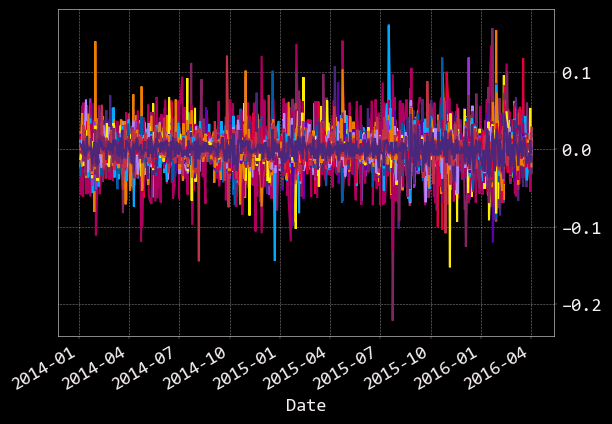

In [11]:
returns.plot(legend=None)

Create a mock portfolio by generating random weights and multiplying them by the returns. You can use your actual weights to represent your own portfolio.



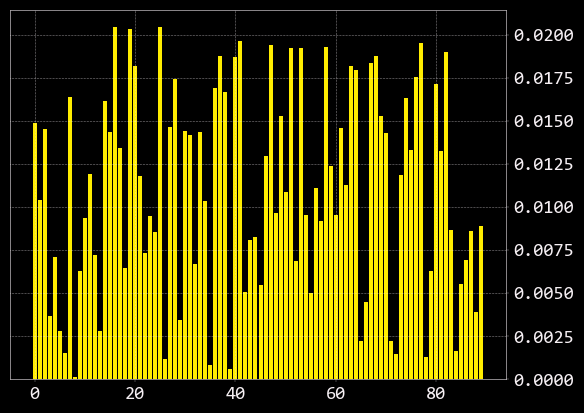

In [12]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights);

## Step 2: Compute VaR and CVaR
Start by building a function to compute VaR so you can compare it to CVaR.

In [13]:
def value_at_risk(
    value_invested, 
    returns, weights, 
    alpha=0.95, 
    lookback_days=500
):
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

First, replace any NaNs with 0.0s in the DataFrame of returns. Then take the last few days of returns and multiply them by the portfolio weights to create portfolio returns. Finally, compute VaR by taking the 5th percentile of returns and multiplying it by the value invested. This gets the amount you can expect to lose in one day with 95% confidence.

This is the main difference between VaR and CVaR. VaR represents a worst-case loss associated with a probability and a time horizon. CVaR is the expected loss if that worst-case threshold is crossed. In other words, CVaR quantifies the expected losses that occur beyond the VaR cutoff. VaR only measures the cutoff.



In [14]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520)

-15490.920976717378

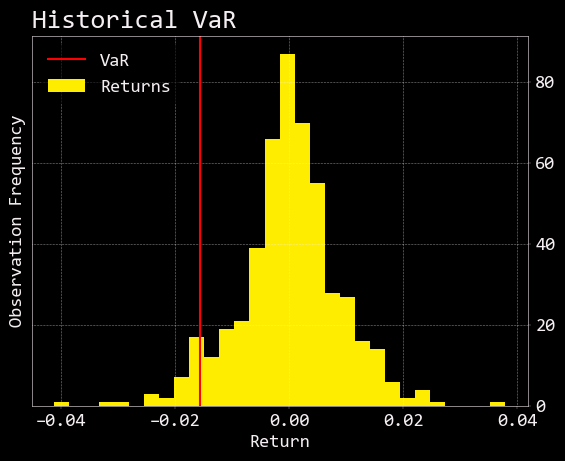

In [15]:
lookback_days = 500
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=30)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR', 'Returns'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

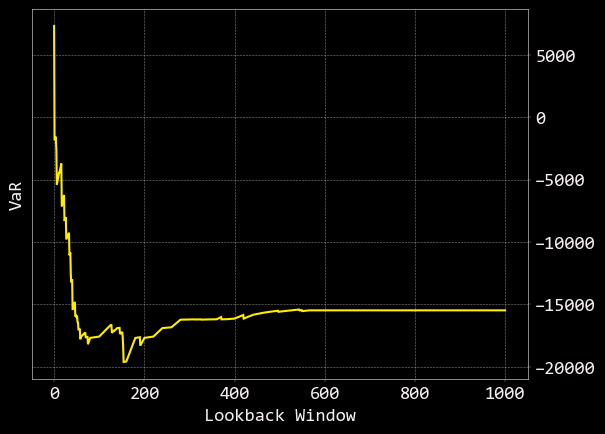

In [16]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days=i+1)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

In [17]:
def cvar(
    value_invested, 
    returns, 
    weights, 
    alpha=0.95, 
    lookback_days=500
):
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    var_pct_loss = var / value_invested
    
    return np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss]) * value_invested

Compute VaR to get the cutoff point on the distribution that equals the 5th percentile. Then compute the portfolio returns and convert VaR back to a percentage instead of a dollar amount. To compute CVaR, take the average of all returns less than VaR and multiply by the invested value.

Taking the average of all returns less than VaR is the same as taking the area of the distribution left of that cutoff point.

## Step 3: Vizualize the difference between the two
Compute the CVaR and VaR of the portfolio and note the difference

In [18]:
cvar(value_invested, returns, weights, lookback_days=500)

-20567.354771813963

In [19]:
value_at_risk(value_invested, returns, weights, lookback_days=500)

-15576.048420791709

CVaR is a bigger negative number than VaR. The difference between the two is the extra information CVaR captures by taking the average of all returns less than VaR. If you are dependent on VaR for risk management, you miss that information.

If this still isn’t clear, a chart will help.

Text(0, 0.5, 'Observation Frequency')

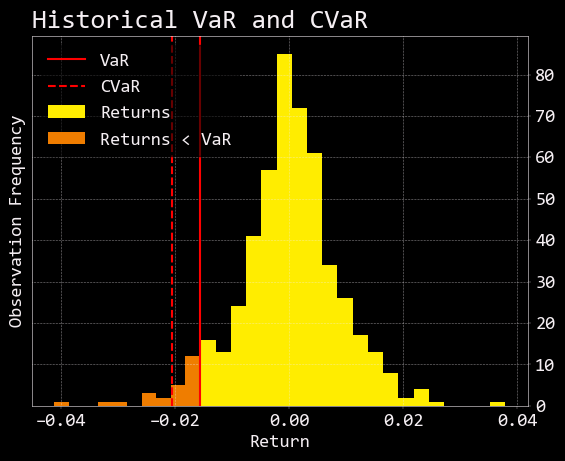

In [20]:
lookback_days = 500

portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights)
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights)
portfolio_CVaR_return = portfolio_CVaR / value_invested

plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid')
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed')
plt.legend(['VaR', 'CVaR', 'Returns', 'Returns < VaR'])
plt.title('Historical VaR and CVaR')
plt.xlabel('Return')
plt.ylabel('Observation Frequency')

The dashed line is CVaR and the solid line is VaR. VaR pinpoints the negative return at the 5th percentile. CVaR averages all the losses left of VaR (the orange bars), including the large negative return.
Returns are not normally distributed. CVaR captures it.